In [148]:
#
#    IMPORTS
# 

#    Import some standard python modules
import os, json, time, datetime
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.
#    
from wildfire import Reader 
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model

import statsmodels.api as sm
import numpy as np

Here, we use the 'wildfire' module to create an instance of the Reader class. We open the data file and print out the headers in order to view the fields present in the data.

In the following cells we provide small code snippets that do the following:

Create a wildfire Reader() object and use it to open the sample data file. Once, opened, we have access to the header information so we print that to show the structure of that data. Use the Reader() object and the next() method to read the set of wildfire features. Access the geometry of the feature to get the 'ring' boundary of that specific fire - which is a list of geodetic coordinates.

Another note regarding terminology. In the GeoJSON standard, something that is to be represented geographically is generically called a 'feature'. In the case of the wildfire dataset every 'feature' is a wildfire. These terms are used somewhat interchangably below.

In [2]:
reader = Reader.Reader()
reader.open("GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json")

In [3]:
header_dict = reader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(header_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))

The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields']

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_Causes": "Listed Fire Causes",
        "Listed_Fire_Cause_Class": "Listed Fire Cause Class",
 

The following helper functions will allow us to calculate the shortest and average distance from the fire to the city.

The first bit of code finds the point on the perimiter with the shortest distance to the city (place) and returns the distance as well as the lat,lon of the perimeter point.

The second bit of code calculates the average distance of all perimeter points to the city (place) and returns that average as the distance. This is not quite what the centroid would be, but it is probably fairly close.

These are two reasonable ways to think about possible distance to a fire. But both require computing distance to a whole set of points on the perimeter of a fire.

In [4]:
# define helper functions for the tasks
# 1. 
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

# 2.
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


# 3.
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

Here, we load the features from the reader into a list of dictionaries so that we can process them into a dataframe for our analysis.

In [ ]:
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
reader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = reader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 10000) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    feature = reader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Here, we analyze each fire. We compute the average distance between the fire boundary and the city of Benicia. We only consider it for our analysis if it was within 1250 miles from our city.

In [ ]:
city_latlon = [38.052147, -122.153893]

final_wildfire_data = []

for wildfire_feature in feature_list:
    
    fire_year = wildfire_feature['attributes']['Fire_Year']
    fire_name = wildfire_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    
    print(f"Analyzing wildfire {fire_name} in the year {fire_year}.")
    
    if fire_year >= 1963:
        
        # Get the geometry for the feature we pulled from the feature_list
        wildfire_geometry = wildfire_feature['geometry']
        
        # Get all the coordinates for the fire boundary
        if list(wildfire_feature['geometry'].keys())[0] == 'curveRings':
            continue;

        ring_data = wildfire_feature['geometry']['rings'][0]
        
        # Compute the average distance between the fire boundary and the city of interest
        distance = average_distance_from_place_to_fire_perimeter(city_latlon,ring_data)
        
        print((f"Wildfire found to have an average distance of {distance:1.2f} miles from Benicia, California"))
        
        if distance <= 1250:
            wildfire_feature['attributes']['Distance'] = distance
            final_wildfire_data.append(wildfire_feature['attributes'])
    

Creating a Smoke Estimate

Having reviewed the metadata and looked over what the features in the dataset look like, I have concluded that a reasonable smoke estimate could be derived from the following factors:

The GIS calculated hectares of the fire polygon calculated by using the Calculate Geometry tool in ArcGIS Pro - GIS Hectares
The average distance from the fire boundary and city of interest ie Benicia, CA - Distance
It is a reasonable assumption that a fire spread over a larger area will generate more smoke. Similarly, a fire burning further away from the city will have less impact on the city in terms of smoke. Based on these two assumptions, the formula that I will be using for the smoke estimate is:

smoke estimate = (GIS_Hectares * 0.00386)/Distance

Note: The GIS_Hectares value is multiplied by 0.00386 in order to convert the unit to miles^2.

In [8]:
wildfire_data_with_estimate = final_wildfire_data

for wf_feature in wildfire_data_with_estimate:
    try:
        area_of_fire = wf_feature['GIS_Hectares']*0.00386
        dist_of_fire = wf_feature['Distance']
    except:
        print("There is a missing attribute")
    smoke_estimate = area_of_fire/dist_of_fire
    wf_feature['Smoke_Estimate'] = smoke_estimate

After calculating the smoke estimate, we create a dataframe to store the necessary attributes for future analysis.

In [125]:
wildfire_est_list = []
for wf_feature in wildfire_data_with_estimate:
    feature = {}
    feature['USGS_Assigned_ID'] = wf_feature['USGS_Assigned_ID']
    feature['Assigned_Fire_Type'] = wf_feature['Assigned_Fire_Type']
    feature['Fire_Year'] = wf_feature['Fire_Year']
    feature['GIS_Hectares'] = wf_feature['GIS_Hectares']
    feature['GIS_Acres'] = wf_feature['GIS_Acres']
    feature['Listed_Fire_Names'] = wf_feature['Listed_Fire_Names']
    feature['Distance'] = wf_feature['Distance']
    feature['Smoke_Estimate'] = wf_feature['Smoke_Estimate']
    wildfire_est_list.append(feature)
# convert to a dataframe
wildfire_df = pd.DataFrame(wildfire_est_list)
wildfire_df.shape

(75362, 8)

This graph is a histogram showing the number of fires occurring every 50 mile distance from Benicia, California up to the max specified distance. The x-axis represents the distance in miles from the assigned city. The distances are divided into 50-mile intervals. Each interval is represented by a bar on the histogram. The y-axis represents the count or frequency of fires that occurred within each 50-mile distance interval. It shows how many fires were recorded in each specific range. Each bar in the histogram represents one of the 50-mile distance intervals. The height of each bar corresponds to the number of fires that occurred in that distance range.

In [ ]:
temp = wildfire_df

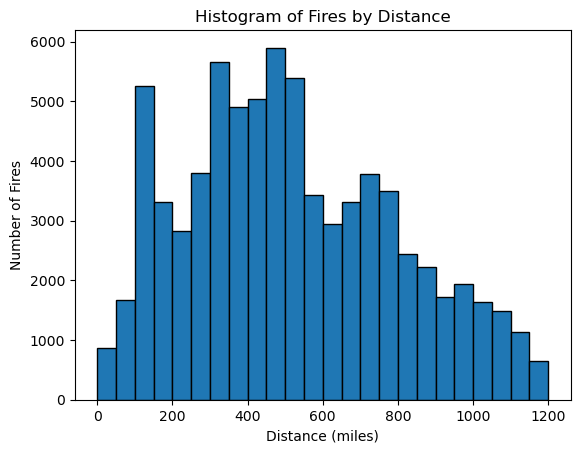

In [174]:
bin_edges = list(range(0, 1250, 50))  # From 0 to 600 miles with 50-mile intervals

# Create the histogram
plt.hist(temp['Distance'], bins=bin_edges, edgecolor='k')

# Set plot labels and title
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Fires')
plt.title('Histogram of Fires by Distance')

# Show the plot
plt.show()

This graph is a time series graph of total acres burned per year for the fires occurring in the specified distance from Benicia, California. The x-axis represents the years during which the fires occurred. Each year is marked along the x-axis, allowing viewers to follow the progression of time. The y-axis represents the total acres burned by fires each year. The units on the y-axis indicate the scale of the total acres burned, which is the variable being measured.

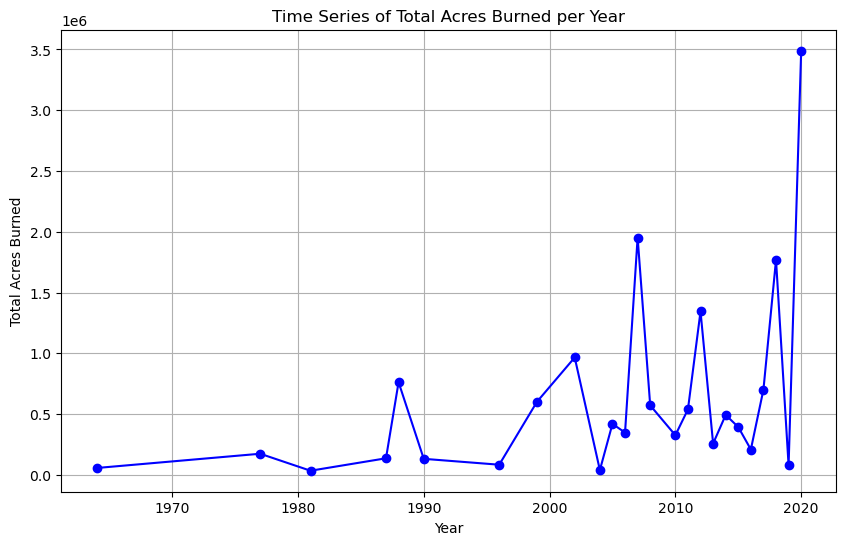

In [175]:
# Group data by 'Fire_Year' and calculate the total acres burned per year
acres_burned_per_year = wildfire_df.groupby('Fire_Year')['GIS_Acres'].sum()

# Create the time series graph
plt.figure(figsize=(10, 6))
acres_burned_per_year.plot(kind='line', marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Time Series of Total Acres Burned per Year')
plt.grid(True)

# Show the plot
plt.show()

Here, we read the CSV file containing data about the Age-Adjusted Premature Death rates into a dataframe. Age-adjusted death rates are weighted averages of the age-specific death rates, where the weights represent a fixed population by age.  The unit for this value is the number of premature deaths per 100,000 individuals. Premature death rate includes all deaths where the deceased is younger than 75 years of age.

In [108]:
df_pd = pd.read_csv('~/Desktop/premat_d.csv')
df_pd

,DATE,CDC20N2UAA006095
0,1999-01-01,376.0
1,2000-01-01,373.0
2,2001-01-01,360.1
3,2002-01-01,371.7
4,2003-01-01,363.4
5,2004-01-01,334.1
6,2005-01-01,365.7
7,2006-01-01,363.1
8,2007-01-01,340.7
9,2008-01-01,329.4


In [109]:
df_pd['DATE'] = pd.to_datetime(df_pd['DATE'])

In [110]:
df_pd['DATE'] = df_pd['DATE'].dt.year

In [111]:
df_pd

,DATE,CDC20N2UAA006095
0,1999,376.0
1,2000,373.0
2,2001,360.1
3,2002,371.7
4,2003,363.4
5,2004,334.1
6,2005,365.7
7,2006,363.1
8,2007,340.7
9,2008,329.4


In [113]:
df_pd = df_pd.rename(columns={"DATE": "Fire_Year", "CDC20N2UAA006095": "Age-Adjusted Premature Death Rate"})
df_pd

,Fire_Year,Age-Adjusted Premature Death Rate
0,1999,376.0
1,2000,373.0
2,2001,360.1
3,2002,371.7
4,2003,363.4
5,2004,334.1
6,2005,365.7
7,2006,363.1
8,2007,340.7
9,2008,329.4


Since the Age-Adjusted Premature Death Rate is the number of premature deaths per 100,000 individuals, we need to scale it down for the population of Benicia which is 26819.

In [114]:
df_pd["Age-Adjusted Premature Death Rate"] = (df_pd["Age-Adjusted Premature Death Rate"]/100000)*26819
df_pd

,Fire_Year,Age-Adjusted Premature Death Rate
0,1999,100.839440
1,2000,100.034870
2,2001,96.575219
3,2002,99.686223
4,2003,97.460246
5,2004,89.602279
6,2005,98.077083
7,2006,97.379789
8,2007,91.372333
9,2008,88.341786


We remove all the wildfires with a scaled smoke estimate lower than 1 as their impact is very low. The only way to get such a low estimate is if the fire was very small and far away from the city resulting in negligible impact.

In [ ]:
wildfire_df = wildfire_df[wildfire_df['Smoke_Estimate'] > 1]
len(wildfire_df)

In [ ]:
We then group the fires by year, averaging over the smoke estimate.

In [139]:
wildfire_df_grouped = wildfire_df.groupby("Fire_Year")["Smoke_Estimate"].mean().reset_index()

In [ ]:
df_merged = pd.merge(df_pd, wildfire_df_grouped, on='Fire_Year', how='inner')
df_merged

We first create a scatterplot in order to analyze the relationship between the Smoke Estimate and the Age-Adjusted Premature Death rate. We can see that the relationship is not exactly linear. We address this issue by controlling for personal income in the subsequent linear regression model.

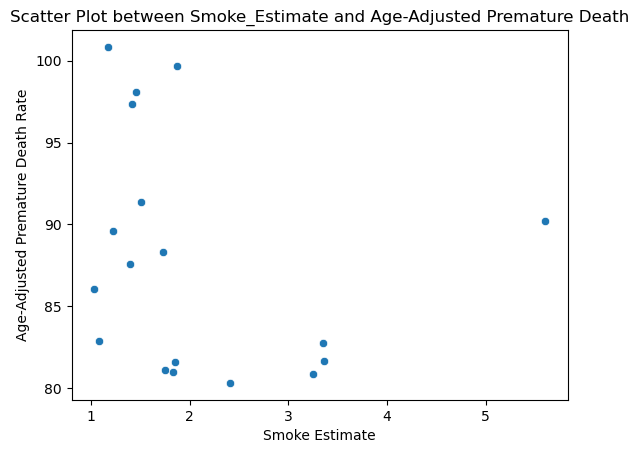

In [141]:
sns.scatterplot(data=df_merged, x="Smoke_Estimate", y="Age-Adjusted Premature Death Rate")

# Set labels and title
plt.xlabel("Smoke Estimate")
plt.ylabel("Age-Adjusted Premature Death Rate")
plt.title(f'Scatter Plot between {"Smoke_Estimate"} and {"Age-Adjusted Premature Death"}')

# Show the plot
plt.show()

Here, we read in the data for per capita personal income. This is the income that is received by persons from all sources. It is calculated as the sum of wages and salaries, supplements to wages and salaries, proprietors' income with inventory valuation and capital consumption adjustments, rental income of persons with capital consumption adjustment, personal dividend income, personal interest income, and personal current transfer receipts, less contributions for government social insurance. This measure of income is calculated as the personal income of the residents of a given area divided by the resident population of the area. 

We extract the year and rename the columns as we did above.

In [ ]:
df_pi = pd.read_csv("PCPI06095.csv")
df_pi

In [ ]:
df_pi['DATE'] = pd.to_datetime(df_pi['DATE'])
df_pi['DATE'] = df_pi['DATE'].dt.year
df_pi = df_pi.rename(columns={"DATE": "Fire_Year", "PCPI06095": "Per capita Personal Income"})
df_pi

We then merge all the data into one dataframe for our linear regression model.

In [142]:
df_merged = pd.merge(df_merged, df_pi, on='Fire_Year', how='inner')
df_merged

,Fire_Year,Age-Adjusted Premature Death Rate,Smoke_Estimate,Per capita Personal Income
0,1999,100.839440,1.171218,26106
1,2002,99.686223,1.869994,30931
2,2004,89.602279,1.226948,32965
3,2005,98.077083,1.452074,33987
4,2006,97.379789,1.409936,35768
5,2007,91.372333,1.508726,37429
6,2008,88.341786,1.729968,38004
7,2010,86.035352,1.031116,37656
8,2011,82.870710,1.082105,38635
9,2012,81.637036,3.359383,38975


Since controlling for income could potentially address the issue of linearity, it has been added as a predictor to the linear regression model defined below. In order to further account for the linearity issue, an interaction term which was the product of the two predictors has been added. Lastly, we print the summary of the model to analyze the fit of the model using the coefficients, p-values, etc.

In [165]:
df_merged['Interaction'] = df_merged['Smoke_Estimate'] * df_merged['Per capita Personal Income']

# Define the predictors (including the interaction term) and the response variable
X = df_merged[['Smoke_Estimate', 'Per capita Personal Income' ,'Interaction']]
y = df_merged['Age-Adjusted Premature Death Rate']

# Add a constant term to the predictors (intercept)
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary to see coefficients, p-values, etc.
print(model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     Age-Adjusted Premature Death Rate   R-squared:                       0.741
Model:                                           OLS   Adj. R-squared:                  0.685
Method:                                Least Squares   F-statistic:                     13.33
Date:                               Mon, 11 Dec 2023   Prob (F-statistic):           0.000218
Time:                                       00:02:53   Log-Likelihood:                -48.148
No. Observations:                                 18   AIC:                             104.3
Df Residuals:                                     14   BIC:                             107.9
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
                                 coef    std err          t 

/Users/ananyanair/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We create a pairplot to visualize the relationships between the predictors and the interaction term.

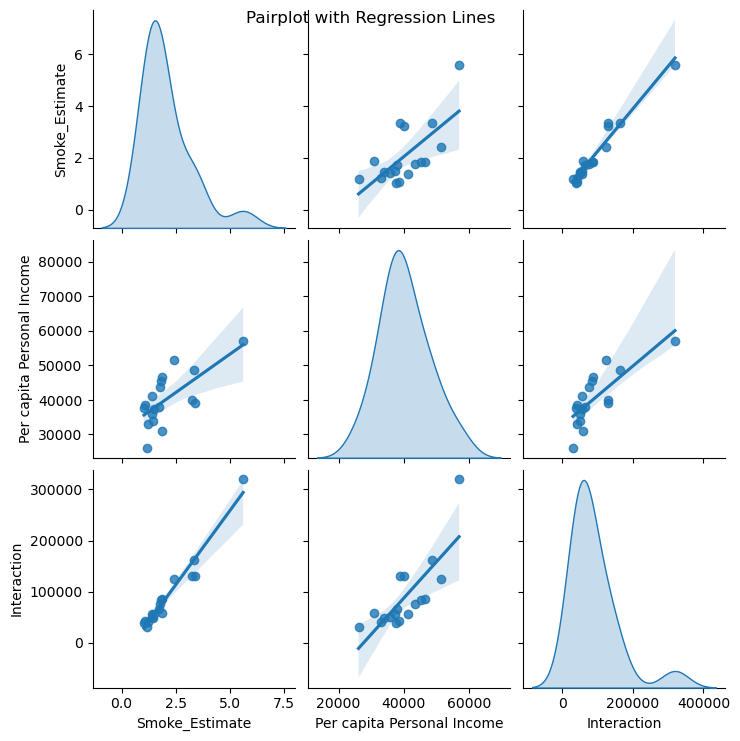

In [176]:
sns.pairplot(df_merged[['Smoke_Estimate', 'Per capita Personal Income' ,'Interaction']], kind='reg', diag_kind='kde')
plt.suptitle('Pairplot with Regression Lines')
plt.show()